# Processing

This notebook is used to create a population point layer that can be used for further processing. The following files are required as input:
- A population grid raster layer. For many european countries, such a file can be downloaded from here: https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Population_and_housing_census_2021_-_population_grids
- A vector file with the boundaries of the country you are interested in. These can be downloaded here (Use type ADM0): https://www.geoboundaries.org/simplifiedDownloads.html

Download the files and place them in the folder "./data/external/".

## Import Libraries

In [20]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import mask
from rasterio.plot import show
from shapely import Point

## Parameters

Set the path to the downloaded input files here.

In [31]:
POPULATION_GRID_PATH = "../data/external/ESTAT_OBS-VALUE-T_2021_V1-0.tiff"
COUNTRY_BOUNDARIES_PATH = "../data/external/geoBoundaries-AUT-ADM0_simplified.geojson"

OUTPUT_PATH = "../data/processed/population_points.gpkg"

## Read Data

### Read Population Data

In [6]:
population_data_src = rasterio.open(POPULATION_GRID_PATH)
population_data = population_data_src.read(1)

grid_crs = population_data_src.crs.to_epsg()

### Read Country Boundary Data

Text(0.5, 1.0, 'Country Border')

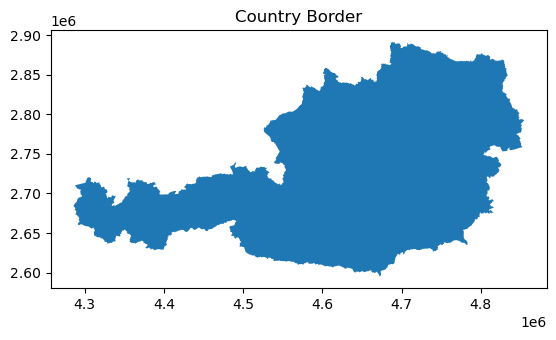

In [12]:
county_boundary = gpd.read_file(COUNTRY_BOUNDARIES_PATH)
county_boundary = county_boundary.to_crs(grid_crs)

# Plot
ax = county_boundary.plot()
ax.set_title("Country Border")

## Mask Population Grid

The population grid is masked by the country boundaries.

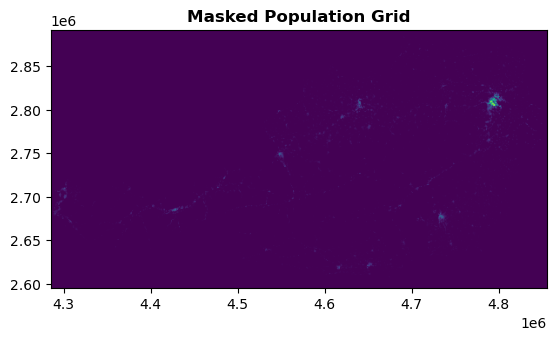

<Axes: title={'center': 'Masked Population Grid'}>

In [28]:
population_data_masked, out_transform = mask.mask(
    population_data_src, county_boundary.geometry, crop=True)

out_meta = population_data_src.meta
out_meta.update({
    "driver": "GTiff",
    "height": population_data_masked.shape[1],
    "width": population_data_masked.shape[2],
    "transform": out_transform})

show(
    population_data_masked, transform=out_transform,
    title="Masked Population Grid")

## Extract Pixel Coordinates

Iterate through each pixel in the masked population grid and extract its coordinates and value.

In [29]:
population_data = population_data_masked[0]

raster_shape = population_data.shape
nodata_value = population_data_src.nodata

coordinates = []
values = []

for pixel_index in np.ndindex(raster_shape):
    pixel_value = int(population_data[pixel_index])
    if pixel_value != nodata_value:
        pixel_coordinates = rasterio.transform.xy(out_transform, pixel_index[0], pixel_index[1])

        coordinates.append(Point(pixel_coordinates))
        values.append(pixel_value)

## Create Point GeoDataFrame

In [30]:
data = {
    "geometry": coordinates,
    "Population Count": values
}

population_points = gpd.GeoDataFrame(data, crs=population_data_src.crs)

population_points.head()

,geometry,Population Count
0,POINT (4687500.000 2890500.000),2
1,POINT (4688500.000 2890500.000),2
2,POINT (4690500.000 2890500.000),0
3,POINT (4686500.000 2889500.000),0
4,POINT (4687500.000 2889500.000),0


## Save Result

In [32]:
population_points.to_file(OUTPUT_PATH, layer="Population Points")